# Tarea 2 - Redes Neuronales Recurrentes (RNNs)

## Parte 1: Detección de Spam

In [1]:
import torch
import random
import time
import matplotlib.pyplot as plt
from torch import nn
from torchtext.legacy import data

# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Text learning setup
SEED = 1999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.long, batch_first=True)

### Actividad 1

In [2]:
# Build dataset from tsv file
spam_dataset = data.TabularDataset(
    path='spam_dataset/spam', 
    format='tsv', 
    fields=[('label', LABEL), ('text', TEXT)])

In [3]:
# Divide between training/testing (70/30 split)
train_data, test_data = spam_dataset.split(random_state=random.seed(SEED))

In [4]:
# Build vocabulary with the GloVe embedding
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size=MAX_VOCAB_SIZE, 
                 vectors='glove.6B.100d', 
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [5]:
print(TEXT.vocab.freqs.most_common(20))

[('.', 3486), ('to', 1488), ('I', 1395), (',', 1333), ('you', 1284), ('?', 1006), ('!', 947), ('a', 937), ('the', 827), ('...', 785), ('i', 693), ('and', 625), ('in', 577), ('is', 567), ('u', 542), ('me', 533), ('..', 464), ('for', 446), ('my', 424), ('it', 423)]


In [6]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '.', 'to', 'I', ',', 'you', '?', '!', 'a']


In [7]:
print(LABEL.vocab.stoi)

defaultdict(None, {'ham': 0, 'spam': 1})


### Actividad 2

In [8]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=1, 
                 lstm=False, bidirectional=False, dropout=0.5, pad_idx=None):
        super().__init__()
        
        # Information
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        
        # Dropout settings
        dropout_value = 0
        if num_layers > 1:
            dropout_value = dropout
        
        # RNN type (Normal/LSTM)
        self.lstm = lstm
        if lstm:
            self.rnn = nn.LSTM(embedding_dim, 
                              hidden_dim, 
                              num_layers=num_layers, 
                              bidirectional=bidirectional, 
                              dropout=dropout_value,
                              batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, 
                              hidden_dim, 
                              num_layers=num_layers, 
                              bidirectional=bidirectional, 
                              dropout=dropout_value,
                              batch_first=True)

        # Dense layers for classification
        n_directions = 1
        if bidirectional:
            n_directions = 2
        self.dim = n_directions * num_layers
        self.dense = nn.Linear(hidden_dim * self.dim, dense_dim)
        self.linear_out = nn.Linear(dense_dim, output_dim)
    
    # This method defines the forward pass of the RNN
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True)
        if self.lstm:
            packed_output, (hidden, cell) = self.rnn(packed_embedded)
        else:
            packed_output, hidden = self.rnn(packed_embedded)
        
        if self.dim > 1:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden.squeeze(0)
        dense = self.dense(hidden)
        return self.linear_out(dense)

In [9]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 80
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

simple_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, pad_idx=pad_idx)

In [10]:
# Check the number of trainable parameters in a model
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
print(f'Trainable Parameters: {num_trainable_parameters(simple_model)}')

Trainable Parameters: 973442


In [12]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 120
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

simple_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, pad_idx=pad_idx)

In [13]:
print(f'Trainable Parameters: {num_trainable_parameters(simple_model)}')

Trainable Parameters: 987922


In [14]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([9539, 100])


In [15]:
simple_model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.2811,  0.4112,  0.3499,  ...,  2.6923, -1.6318,  1.9040],
        [-0.3175, -0.0607, -2.2068,  ..., -0.7107,  0.6260, -0.0505],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])

In [16]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

simple_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
simple_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(simple_model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])


### Actividad 3

In [17]:
# Round the output value to binary values
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    _, pred_labels = torch.max(rounded_preds, dim=1)
    correct = (pred_labels == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train for one epoch
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  # Training mode
    for batch in iterator:
        # Reset gradients & predict
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        
        # Compute loss & accuracy, run backprop and update weights
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        # Metrics
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Test for one epoch
def test(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  # Eval mode
    with torch.no_grad():
        for batch in iterator:
            # Get predictions
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            
            # Compute loss & accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            # Metrics
            epoch_loss += loss.item()
            epoch_acc += acc.item()   
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Run training
def run_training(model, iterator, optimizer, criterion, n_epochs):
    history = {'acc': [], 'loss': []}
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # Train one epoch
        train_loss, train_acc = train(model, iterator, optimizer, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # Display information
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        
        # Save metrics history
        history['acc'].append(round(train_acc, 2))
        history['loss'].append(round(train_loss, 2))
    return history

# Run testing
def run_testing(model, iterator, criterion):
    test_loss, test_acc = test(model, iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    return round(test_acc, 2), round(test_loss, 2)

In [18]:
# Define iterators for the data
batch_size = 64

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

In [19]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 5
lr = 0.01

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=lr)

# Model & Criterion to GPU
simple_model = simple_model.to(device)
criterion = criterion.to(device)

In [20]:
# Run training
train_history = run_training(simple_model, train_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.351 | Train Acc: 88.34%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.138 | Train Acc: 95.31%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.056 | Train Acc: 98.31%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.022 | Train Acc: 99.51%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.017 | Train Acc: 99.64%


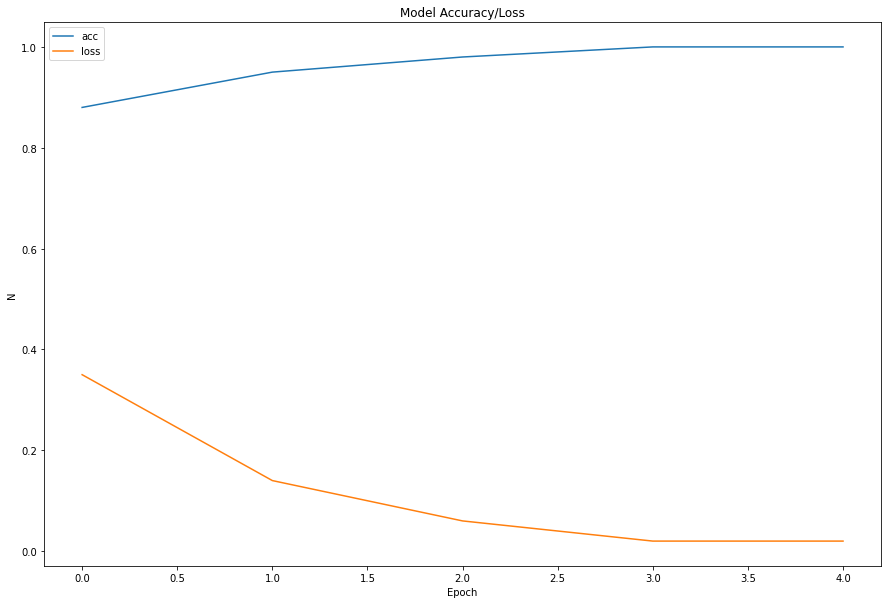

In [21]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(train_history['acc'])
plt.plot(train_history['loss'])
plt.title('Model Accuracy/Loss')
plt.ylabel('N')
plt.xlabel('Epoch')
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

In [22]:
# Run testing
test_acc, test_loss = run_testing(simple_model, test_iterator, criterion)

Test Loss: 0.111 | Test Acc: 97.11%


### Actividad 4

In [23]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 120
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

lstm_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, lstm=True, pad_idx=pad_idx)

In [24]:
print(f'Trainable Parameters: {num_trainable_parameters(lstm_model)}')

Trainable Parameters: 1067842


In [25]:
lstm_model.embedding.weight.data.copy_(pretrained_embeddings)

unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

lstm_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
lstm_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(lstm_model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])


In [26]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 5
lr = 0.01

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

# Model & Criterion to GPU
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [27]:
# Run training
train_history = run_training(lstm_model, train_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.287 | Train Acc: 89.47%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.057 | Train Acc: 98.34%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.015 | Train Acc: 99.62%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.004 | Train Acc: 99.90%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.005 | Train Acc: 99.92%


In [29]:
# Run testing
test_acc, test_loss = run_testing(lstm_model, test_iterator, criterion)

Test Loss: 0.143 | Test Acc: 96.93%


### Actividad 5

In [36]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 120
dense_dim = 60
output_dim = 2
num_layers = 1
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

best_model = RNN(input_dim, embedding_dim, hidden_dim, dense_dim, output_dim, num_layers=num_layers, lstm=True, bidirectional=True, pad_idx=pad_idx)

In [37]:
print(f'Trainable Parameters: {num_trainable_parameters(best_model)}')

Trainable Parameters: 1181602


In [38]:
best_model.embedding.weight.data.copy_(pretrained_embeddings)

unk_idx = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
best_model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(best_model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [-0.0346,  0.2088,  0.2014,  ..., -0.6978,  0.3013, -0.5122],
        [-0.0426, -0.0842, -0.3309,  ..., -0.9232,  0.0126,  0.2147],
        [ 0.0147,  0.1726,  1.1608,  ..., -0.4003,  0.7675,  0.7384]])


In [39]:
# Hyperparameters: number of epochs and learning rate
n_epochs = 5
lr = 0.01

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)

# Model & Criterion to GPU
best_model = best_model.to(device)
criterion = criterion.to(device)

In [40]:
# Run training
train_history = run_training(best_model, train_iterator, optimizer, criterion, n_epochs)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.316 | Train Acc: 90.47%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.050 | Train Acc: 98.44%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.010 | Train Acc: 99.77%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.004 | Train Acc: 99.82%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.001 | Train Acc: 99.97%


In [41]:
# Run testing
test_acc, test_loss = run_testing(best_model, test_iterator, criterion)

Test Loss: 0.061 | Test Acc: 98.67%


## Parte 2: Aprendizaje de Similitud entre Oraciones

### Actividad 6

### Actividad 7

Comenzamos importando un modelo pre-entrenado de ResNet-50:

### Actividad 8

A continuación se definen diversas funciones en PyTorch para poder realizar el fine-tuning con ResNet-50 **[1]**:

Se cargan los datasets de flores, aplicando una transformación para dejar todas las imágenes del mismo tamaño, y posteriormente normalizar sus tensores resultantes:

Se re-entrena el modelo por 20 épocas (a partir de su versión pre-entrenada), utilizando Cross Entropy Loss para la función de pérdida y Stochastic Gradient Descent para el optimizador:

A continuación se grafica la evolución de la pérdida a través de las épocas:

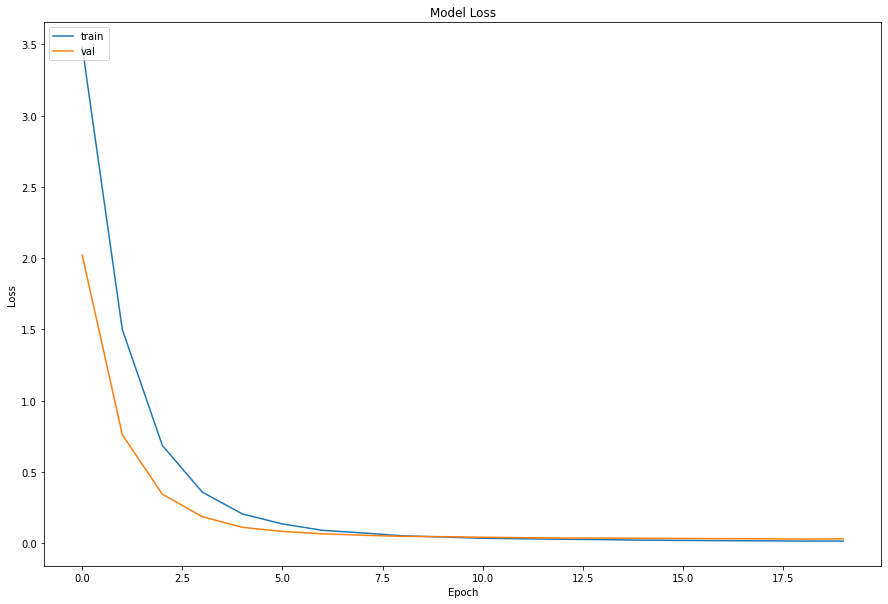

In [5]:
# History for epoch loss
plt.figure(figsize=(15, 10))
plt.plot(history['training']['loss'])
plt.plot(history['validation']['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se puede observar que la pérdida disminuye rápidamente en ambos sets, llegando a un valor casi mínimo alrededor de la época 8. La diferencia inicial se debe a que la validación ocurre posterior a la primera pasada por el set de entrenamiento, teniendo entonces los pesos ya mejorados con respecto al modelo pre-entrenado inicial. Tras la época 8, existe muy poca variación de la pérdida en ambos sets.

A continuación se grafica la evolución de la exactitud a través de las épocas:

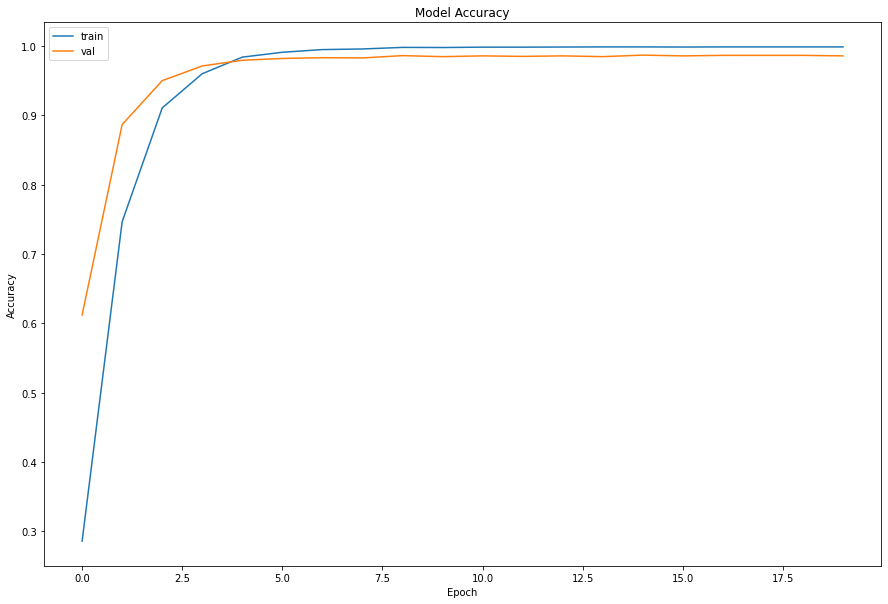

In [6]:
# History for epoch accuracy
plt.figure(figsize=(15,10))
plt.plot(history['training']['acc'])
plt.plot(history['validation']['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Se puede observar que la exactitud aumenta muy rápido en ambos sets, llegando a un techo alrededor de la época 7. Aún así, el set de validación alcanza una menor exactitud final, evidenciando que ocurre un ligero overfitting desde la época 4 (aprox.) en adelante.

Se procede a guardar los parámetros del modelo, de forma que no sea necesario entrenarlo nuevamente **[3]**:

In [7]:
torch.save(model.state_dict(), 'flowers.pt')

Primero se carga el modelo entrenado en la actividad anterior **[3]**:

In [3]:
flowers_model = get_model(102, True)
flowers_model.load_state_dict(torch.load('flowers.pt'))
flowers_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Referencias

[1] Save/Load Models in Pytorch: https://pytorch.org/tutorials/beginner/saving_loading_models.html